In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'

In [372]:
def mesher2D(nrows,ncols,length,height,deg=1):
    '''
    This is a function for creating a mesh of 2D rectilinear elements. It assumes the points are laid out in a grid.
    Currently, only linear elements are supported.

    Inputs
    ------
    nrows: integer. Number of elements in a row
    ncols: integer. Number of elements in a column
    length: float. Length of the domain
    height: float. Height of the domain

    Returns
    -------
    node_dict: dictionary. A multi-level dictionary with the global node numbers as the outer keys, and the inner dictionary
    for each global node containing the x and y coordinates of that node.
    
    elem_nodes: array. An array where each row is an element, counting left to right, bottom to top of the domain,
    and each entry for each element are the global node numbers, counting counter-clockwise from the upper right node.

    '''
    if nrows*ncols%2 != 0:
        root = np.sqrt(nrows*ncols)
        if root - int(root) > 0.0: # checks for a perfect square
            raise ValueError('Uneven grid detected.')
        # else:
        #     print('Square domain detected.')
    n_xnodes = ncols + 1
    n_ynodes = nrows + 1
    dx = length/ncols
    dy = height/nrows
    xnodes = np.arange(0,length+dx,dx)
    ynodes = np.arange(0,height+dy,dy)
    X,Y = np.meshgrid(xnodes,ynodes)
    if deg==1:
        nodes_per_elem=4
    elem_nodes = np.zeros((nrows*ncols,nodes_per_elem),dtype='int')
    # row = 0
    # for e in range(nrows*ncols):
    #     # print(e+row,e+1+row,e+nrows+1+row,e+nrows+2+row)
    #     elem_nodes[e] = e+nrows+2+row,e+nrows+1+row,e+row,e+1+row
    #     if (e%(ncols-1) == 0.0 and e!=0):
    #         row += 1
    for row in range(nrows):
        for col in range(ncols):
            elem_nodes[nrows*row+col] = n_xnodes*(row+1)+(col+1),n_xnodes*(row+1)+col,n_xnodes*row+col,n_xnodes*row+col+1
    node_dict = {}
    node_count = 0
    for i in range(nrows+1):
        for j in range(ncols+1):
            node_dict[node_count] = {'x':X[i,j],'y':Y[i,j]}
            node_count += 1
    return node_dict, elem_nodes

def retrieve_coords(node_dict,elem_nodes,eid):
    nodes = elem_nodes[eid]
    x = []
    y = []
    for node in nodes:
        xval = node_dict[node]['x']
        yval = node_dict[node]['y']
        x.append(xval)
        y.append(yval)
    coords = np.concatenate((x,y))
    return coords

def ref_square_basis(Xi,Eta):
    N1 = 0.25*(1+Xi)*(1+Eta)
    N2 = 0.25*(1-Xi)*(1+Eta)
    N3 = 0.25*(1-Xi)*(1-Eta)
    N4 = 0.25*(1+Xi)*(1-Eta)
    return [N1,N2,N3,N4]

def square_basis_derivs(Xi,Eta):
    dN1xi = 0.25*(1+Eta)
    dN2xi = -0.25*(1+Eta)
    dN3xi = -0.25*(1-Eta)
    dN4xi = 0.25*(1-Eta)
    dN1eta = 0.25*(1+Xi)
    dN2eta = 0.25*(1-Xi)
    dN3eta = -0.25*(1-Xi)
    dN4eta = -0.25*(1+Xi)
    return [dN1xi,dN2xi,dN3xi,dN4xi],[dN1eta,dN2eta,dN3eta,dN4eta]

def square_jacobian(coords,dNxi,dNeta):
    dNxi=np.array(dNxi)
    dNeta=np.array(dNeta)
    # coordinates in this function are passed x first, then y
    x = np.array(coords[:len(coords)//2])
    y = np.array(coords[len(coords)//2:])
    dxdxi = np.dot(x,dNxi)
    dxdeta = np.dot(x,dNeta)
    dydxi = np.dot(y,dNxi)
    dydeta = np.dot(y,dNeta)
    # dxdxi = sum([x_*dN for x_,dN in zip(x,dNxi)])
    # dxdeta = sum([x_*dN for x_,dN in zip(x,dNeta)])
    # dydxi = sum([y_*dN for y_,dN in zip(y,dNxi)])
    # dydeta = sum([y_*dN for y_,dN in zip(y,dNeta)])
    return np.array([[dxdxi,dydxi],[dxdeta,dydeta]])

def gauss_points(npts=4):
    '''
    Gaussian quadrature weights and points in the reference element
    '''
    if npts == 4:
        # 4-point square, CCW from upper right
        xi1 = np.sqrt(1/3)
        xi2 = -np.sqrt(1/3)
        xi3 = -np.sqrt(1/3)
        xi4 = np.sqrt(1/3)
        eta1 = np.sqrt(1/3)
        eta2 = np.sqrt(1/3)
        eta3 = -np.sqrt(1/3)
        eta4 = -np.sqrt(1/3)
        weights = np.array([1.,1.,1.,1.])
        xi = np.array([xi1,xi2,xi3,xi4])
        eta = np.array([eta1,eta2,eta3,eta4])
    elif npts == 8:
        val = 3/5
        wo = (5/9)**2
        we = 5*8/(9**2)
        w9 = (8/9)**2
        xi1,eta1 = np.sqrt(val), np.sqrt(val)
        xi2,eta2 = 0.0, np.sqrt(val)
        xi3,eta3 = -np.sqrt(val), np.sqrt(val)
        xi4,eta4 = -np.sqrt(val), 0.0
        xi5,eta5 = -np.sqrt(val), -np.sqrt(val)
        xi6,eta6 = 0.0, -np.sqrt(val)
        xi7,eta7 = np.sqrt(val), -np.sqrt(val)
        xi8,eta8 = np.sqrt(val), 0.0
        xi9,eta9 = 0.0, 0.0
        xi = np.array([xi1,xi2,xi3,xi4,xi5,xi6,xi7,xi8,xi9])
        eta = np.array([eta1,eta2,eta3,eta4,eta5,eta6,eta7,eta8,eta9])
        weights = np.array([wo,we,wo,we,wo,we,wo,we,w9])
    return xi, eta, weights

def globalK(elem_nodes,eid,k,K):
    nodes = elem_nodes[eid]
    rows,cols = k.shape
    nodes_rows = int(np.sqrt(len(nodes)))
    nodes.reshape(nodes_rows,nodes_rows)
    for row in range(rows):
        for col in range(cols):
            K[nodes[row],nodes[col]] += k[row,col]
    return K

def globalF(elem_nodes,eid,f,F):
    nodes = elem_nodes[eid]
    rows = len(f)
    for row in range(rows):
        F[nodes[row]] += f[row]
    return F
            
def KCond(kcond,dNxi,dNeta,J):
    Jinv = np.linalg.inv(J)
    dNx = np.array(dNxi).reshape(-1,1)
    dNe = np.array(dNeta).reshape(-1,1)
    K1 = np.hstack((dNx,dNe))
    K2 = np.vstack((dNx.T,dNe.T))
    K = kcond*K1@Jinv.T@Jinv@K1.T*np.linalg.det(J)
    return K

def KConv(hz,N,J):
    Narr = np.array(N).reshape(-1,1)
    K = hz*np.outer(Narr,Narr.T)*np.linalg.det(J)
    return K

def fluxes(nelemsx,nelemsy,nodes,qtop,qbot,qright):
    nxnodes = nelemsx + 1
    nynodes = nelemsy + 1
    nnodes = nxnodes*nynodes
    arr = np.zeros((nynodes,nxnodes))
    arr[:,0] += 1
    arr[0,:] += 2
    arr[-1,:] += 2
    arr[:,-1] += 2
    arr = arr.flatten()
    fluxes = {}
    if arr[nodes[0]] >= 2 and arr[nodes[1]] >= 2:
        fluxes['top'] = qtop
    else:
        fluxes['top'] = 0.0
    if arr[nodes[2]] >= 2 and arr[nodes[3]] >= 2:
        fluxes['bottom'] = qbot
    else:
        fluxes['bottom'] = 0.0
    if arr[nodes[3]] >= 2 and arr[nodes[0]] >= 2:
        fluxes['right'] = qright
    else:
        fluxes['right'] = 0.0
    fluxes['left'] = 0.0
    return fluxes, arr

def f_bcs(coords,nodes,fluxes):
    edges = ['top','bottom','left','right']
    x = coords[:len(coords)//2]
    y = coords[len(coords)//2:]
    f = np.zeros(4)
    W = [1.0,1.0]
    q = fluxes
    for edge in edges:
        if edge == 'top':
            Etav = [1.0, 1.0]
            Eta = [np.sqrt(1/3),np.sqrt(1/3)]
            Xiv = [np.sqrt(1/3),-np.sqrt(1/3)]
            Xi = [np.sqrt(1/3),-np.sqrt(1/3)]
            idx = [0,1]
        if edge == 'left':
            Xiv = [-1.0, -1.0]
            Xi = [-np.sqrt(1/3),-np.sqrt(1/3)]
            Eta = [np.sqrt(1/3),-np.sqrt(1/3)]
            Etav = [np.sqrt(1/3),-np.sqrt(1/3)]
            idx = [1,2]
        if edge == 'bottom':
            Etav = [-1.0, -1.0]
            Eta = [-np.sqrt(1/3),-np.sqrt(1/3)]
            Xiv = [-np.sqrt(1/3),np.sqrt(1/3)]
            Xi = [-np.sqrt(1/3),np.sqrt(1/3)]
            idx = [2,3]
        if edge == 'right':
            Xiv = [1.0, 1.0]
            Xi = [np.sqrt(1/3),np.sqrt(1/3)]
            Etav = [-np.sqrt(1/3),np.sqrt(1/3)]
            Eta = [-np.sqrt(1/3),np.sqrt(1/3)]
            idx = [3,0]
        for i,(xiv,etav,w) in enumerate(zip(Xiv,Etav,W)):
            Nv = np.array(ref_square_basis(xiv,etav))
            dNx,dNe = square_basis_derivs(xiv,etav)
            node1 = nodes[idx[0]]
            node2 = nodes[idx[1]]
            dTdn = q[node1][edge]*Nv[idx[0]]+q[node2][edge]*Nv[idx[1]]
            if edge == 'top' or edge == 'bottom':
                dN = dNx
            else:
                dN = dNe
            transform = sum(dN*x)**2 + sum(dN*y)**2
            f[idx[i]] += Nv[0]*dTdn*np.sqrt(transform)*w
    return f

def f_rhs(N,Tinf,hz,J):
    N = np.array(N)
    return N*hz*Tinf*np.linalg.det(J)

def boundary_flux(nelemsx,nelemsy,nodes,edge):
    qtop = -500
    qright = -1000
    qbot = -1500
    qleft = 0.0
    arr = np.zeros((nelemsy+1,nelemsx+1))
    arr[:,-1] = 1.0
    arr[-1,1:] += 1.0
    arr[0,1:] += 1.0
    # arr[:,0] = 0
    arr = arr.flatten()
    if edge == 'top':
        q1, q2 = arr[nodes[0]]*qtop, arr[nodes[1]]*qtop
    elif edge == 'left':
        q1, q2 = arr[nodes[1]]*qleft, arr[nodes[2]]*qleft
    elif edge == 'bottom':
        q1, q2 = arr[nodes[2]]*qbot, arr[nodes[3]]*qbot
    else:
        q1, q2 = arr[nodes[3]]*qright, arr[nodes[0]]*qright
        
    return q1, q2

    
def flux_dict(elem_nodes,nelemsx,nelemsy):
    nx = nelemsx+1
    ny = nelemsy+1
    d = {}
    nx = nelemsx+1
    ny = nelemsy+1
    arr = np.zeros((ny,nx))
    arr[0,:] += 1
    arr[-1,:] += 2
    arr[:,-1] += 3
    qtop = -500
    qright = -1000.
    qbot = -1500.
    arr = arr.flatten()
    for i in range(nx*ny):
        fluxes = {}
        val = arr[i]
        if val == 1.0:
            fluxes['bottom'] = qbot
            fluxes['top'] = 0.0
            fluxes['left'] = 0.0
            fluxes['right'] = 0.0
        elif val == 2.0:
            fluxes['top'] = qtop
            fluxes['left'] = 0.0
            fluxes['bottom'] = 0.0
            fluxes['right'] = 0.0
        elif val == 3.0:
            fluxes['right'] = qright
            fluxes['left'] = 0.0
            fluxes['bottom'] = 0.0
            fluxes['top'] = 0.0
        elif val == 4.0:
            fluxes['top'] = 0.0
            fluxes['right'] = qright
            fluxes['left'] = 0.0
            fluxes['bottom'] = qbot
        elif val == 5.0:
            fluxes['bottom'] = 0.0
            fluxes['right'] = qright
            fluxes['left'] = 0.0
            fluxes['top'] = qtop
        else:
            fluxes['bottom'] = 0.0
            fluxes['right'] = 0.0
            fluxes['left'] = 0.0
            fluxes['top'] = 0.0
        d[i] = fluxes
    return d

def lin_basis(x):
    N1 = (x-x[-1])/(x[0]-x[-1])
    N2 = (x-x[0])/(x[-1]-x[0])

    return [N1,N2]
            
def rhs_bcs(coords,nodes,fluxes):
    edges = ['top','bottom','left','right']
    x = coords[:len(coords)//2]
    y = coords[len(coords)//2:]
    f = np.zeros(4)
    print(nodes)
    for i,edge in enumerate(edges):
        if edge == 'top':
            idx = [0,1]
            int_range = np.linspace(x[idx[0]],x[idx[1]])
        if edge == 'left':
            idx = [1,2]
            int_range = np.linspace(y[idx[0]],y[idx[1]])
        if edge == 'bottom':
            idx = [2,3]
            int_range = np.linspace(x[idx[0]],x[idx[1]])
        if edge == 'right':
            idx = [3,0]
            int_range = np.linspace(y[idx[0]],y[idx[1]])
        node1 = nodes[idx[0]]
        node2 = nodes[idx[1]]
        print(f'edge:{edge}\tnode1:{node1}\tnode2:{node2}')
        q1 = fluxes[node1][edge]
        q2 = fluxes[node2][edge]
        N = lin_basis(int_range)
        print(q1,q2)
        dTdn = q1*N[0] + q2*N[1]
        val = np.trapz(N[0]*dTdn,x=int_range)
        f[i] += val
    return f

In [1]:
nelemsx = 5
nelemsy = 5
nnodes = (nelemsx+1)*(nelemsy+1)
L = 2.
H = 2.
x = np.linspace(0,L,nelemsx+1)
y = np.linspace(0,H,nelemsy+1)
X,Y = np.meshgrid(x,y)
t = 0.05
Twall = 80.
Tinf = 30.
kcond = 5.
hconv = 10.
qtop = -500
qright = -1000.
qbot = -1500.
hz = 2*hconv/t
node_dict, elem_nodes = mesher2D(nelemsy,nelemsx,L,H,1)
flux_dictionary = flux_dict(elem_nodes,nelemsx,nelemsy)

NameError: name 'np' is not defined

In [ ]:
K = np.zeros((nnodes,nnodes))
F = np.zeros(nnodes)
for e in range(nelemsx*nelemsy):
    coords = retrieve_coords(node_dict,elem_nodes,e)
    nodes = elem_nodes[e]
    # muh_fluxes, bcs_arr = fluxes(nelemsx,nelemsy,nodes,qtop,qbot,qright)
    x = coords[:len(coords)//2]
    y = coords[len(coords)//2:]
    Xi,Eta,W = gauss_points()
    # dNx,dNe = square_basis_derivs(Xi,Eta)
    Kcond = np.zeros((4,4))
    Kconv = np.zeros((4,4))
    Fbcs = np.zeros(4)
    Frhs = np.zeros(4)
    # edges = ['top','left','bottom','right']
    for xi,eta,w in zip(Xi,Eta,W):
        # flux = boundary_flux(nelemsx,nelemsy,nodes,edge)
        N = ref_square_basis(xi,eta)
        dNx,dNe = square_basis_derivs(xi,eta)
        J = square_jacobian(coords,dNx,dNe)
        ktemp = KCond(kcond,dNx,dNe,J)
        Kcond += ktemp*w
        ktemp = KConv(hz,N,J)
        Kconv += ktemp*w
        frhs = f_rhs(N,Tinf,hz,J)
        Frhs += frhs*w
    fbcs = f_bcs(coords,nodes,flux_dictionary)
    Fbcs += fbcs
    for i,row in enumerate(nodes):
        F[row] += (Fbcs[i]+Frhs[i])
        for j,col in enumerate(nodes):
            K[row,col] += (Kcond[i,j]+Kconv[i,j]) 
for idx,node in enumerate(bcs_arr):
    if node == 1 or node == 3:
        K[idx,idx] = 10e8
        F[idx] = Twall*10e8   

In [2]:
sol = np.linalg.solve(K,F)

NameError: name 'np' is not defined

In [3]:
sol

NameError: name 'sol' is not defined

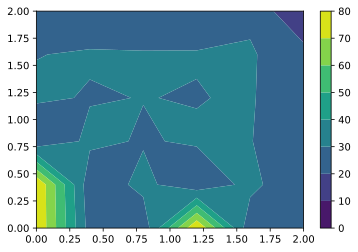

In [382]:
i = int(np.sqrt(len(sol)))
x = np.linspace(0,L,nelemsx+1)
y = np.linspace(0,H,nelemsy+1)
X,Y = np.meshgrid(x,y)
Z = sol.reshape(i,i)
plt.contourf(X,Y,Z)
plt.colorbar()
plt.show()

In [360]:
F

array([8.00000000e+10, 1.66666667e+03, 1.66666667e+03, 8.00000000e+10,
       2.66666667e+03, 5.33333333e+03, 8.00000000e+10, 2.00000000e+03,
       2.66666667e+03, 5.33333333e+03, 5.33333333e+03, 2.00000000e+03,
       1.16666667e+03, 2.33333333e+03, 2.33333333e+03, 8.33333333e+02])

In [361]:
flux_dictionary

{0: {'bottom': -1500.0, 'top': 0.0, 'left': 0.0, 'right': 0.0},
 1: {'bottom': -1500.0, 'top': 0.0, 'left': 0.0, 'right': 0.0},
 2: {'bottom': -1500.0, 'top': 0.0, 'left': 0.0, 'right': 0.0},
 3: {'top': 0.0, 'right': -1000.0, 'left': 0.0, 'bottom': -1500.0},
 4: {'bottom': 0.0, 'right': 0.0, 'left': 0.0, 'top': 0.0},
 5: {'bottom': 0.0, 'right': 0.0, 'left': 0.0, 'top': 0.0},
 6: {'bottom': 0.0, 'right': 0.0, 'left': 0.0, 'top': 0.0},
 7: {'right': -1000.0, 'left': 0.0, 'bottom': 0.0, 'top': 0.0},
 8: {'bottom': 0.0, 'right': 0.0, 'left': 0.0, 'top': 0.0},
 9: {'bottom': 0.0, 'right': 0.0, 'left': 0.0, 'top': 0.0},
 10: {'bottom': 0.0, 'right': 0.0, 'left': 0.0, 'top': 0.0},
 11: {'right': -1000.0, 'left': 0.0, 'bottom': 0.0, 'top': 0.0},
 12: {'top': -500, 'left': 0.0, 'bottom': 0.0, 'right': 0.0},
 13: {'top': -500, 'left': 0.0, 'bottom': 0.0, 'right': 0.0},
 14: {'top': -500, 'left': 0.0, 'bottom': 0.0, 'right': 0.0},
 15: {'bottom': 0.0, 'right': -1000.0, 'left': 0.0, 'top': -500}

In [320]:
2000/1750

1.1428571428571428